In [1]:
!pip install -q openai-whisper
!pip install -q transformers accelerate
!pip install -q torch torchvision
!pip install -q opencv-python
!pip install -q groq

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 803.2/803.2 kB 9.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.3/138.3 kB 4.3 MB/s eta 0:00:00


In [2]:
import os
os.environ["GROQ_API_KEY"] = "YOUR_KEY_HERE"


In [3]:
import whisper
import torch
import cv2
import numpy as np
import json
from dataclasses import dataclass
from typing import List, Dict
from transformers import CLIPProcessor, CLIPModel

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
CONFIDENCE_THRESHOLD = 0.85
FRAME_INTERVAL_SEC = 1
TOP_K_FRAMES = 3

In [30]:
import time
from contextlib import contextmanager

@contextmanager
def timer(name):
    start = time.time()
    yield
    print(f"⏱ {name}: {time.time() - start:.2f}s")


In [4]:
whisper_model = whisper.load_model("large-v3")
clip_model = CLIPModel.from_pretrained("openai/clip-vit-large-patch14").to(DEVICE)
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-large-patch14")
clip_model.eval()

100%|██████████████████████████████████████| 2.88G/2.88G [00:25<00:00, 119MiB/s]


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/1.71G [00:00<?, ?B/s]

Loading weights:   0%|          | 0/590 [00:00<?, ?it/s]

CLIPModel LOAD REPORT from: openai/clip-vit-large-patch14
Key                                  | Status     |  | 
-------------------------------------+------------+--+-
text_model.embeddings.position_ids   | UNEXPECTED |  | 
vision_model.embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

The image processor of type `CLIPImageProcessor` is now loaded as a fast processor by default, even if the model checkpoint was saved with a slow processor. This is a breaking change and may produce slightly different outputs. To continue using the slow processor, instantiate this class with `use_fast=False`. 


tokenizer_config.json:   0%|          | 0.00/905 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

CLIPModel(
  (text_model): CLIPTextTransformer(
    (embeddings): CLIPTextEmbeddings(
      (token_embedding): Embedding(49408, 768)
      (position_embedding): Embedding(77, 768)
    )
    (encoder): CLIPEncoder(
      (layers): ModuleList(
        (0-11): 12 x CLIPEncoderLayer(
          (self_attn): CLIPAttention(
            (k_proj): Linear(in_features=768, out_features=768, bias=True)
            (v_proj): Linear(in_features=768, out_features=768, bias=True)
            (q_proj): Linear(in_features=768, out_features=768, bias=True)
            (out_proj): Linear(in_features=768, out_features=768, bias=True)
          )
          (layer_norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): CLIPMLP(
            (activation_fn): QuickGELUActivation()
            (fc1): Linear(in_features=768, out_features=3072, bias=True)
            (fc2): Linear(in_features=3072, out_features=768, bias=True)
          )
          (layer_norm2): LayerNorm((768,), eps=1e-05,

In [35]:
def transcribe_video(video_path):

    result = whisper_model.transcribe(
        video_path,
        word_timestamps=True
    )

    segments_out = []
    full_text = ""

    for seg in result["segments"]:
        segments_out.append({
            "start": seg["start"],
            "end": seg["end"],
            "text": seg["text"]
        })
        full_text += seg["text"] + " "

    return segments_out, full_text.strip()


In [6]:
def build_context(segments, idx, window=3):
    start = max(0, idx - (window - 1))
    context_segments = segments[start:idx+1]
    text = " ".join([s["text"] for s in context_segments])
    start_time = context_segments[0]["start"]
    end_time = context_segments[-1]["end"]
    return text.strip(), start_time, end_time


In [7]:
from groq import Groq

client = Groq()
# print(client.models.list())

def call_llm(prompt: str) -> str:
    response = client.chat.completions.create(
        model="llama-3.3-70b-versatile",  # UPDATED MODEL
        messages=[
            {
                "role": "system",
                "content": "You are a strict JSON extraction engine. Output ONLY valid JSON."
            },
            {
                "role": "user",
                "content": prompt
            }
        ],
        temperature=0.0,
        max_tokens=512,
        top_p=0.9
    )

    return response.choices[0].message.content.strip()


In [8]:
def safe_extract(prompt):
    raw = call_llm(prompt)

    try:
        parsed = json.loads(raw)

        # If model returns list, extract first element
        if isinstance(parsed, list) and len(parsed) > 0:
            parsed = parsed[0]

        # Ensure dictionary format
        if not isinstance(parsed, dict):
            raise ValueError("Not dict")

        return parsed

    except:
        # Retry once
        retry_prompt = prompt + "\nREMINDER: Output ONLY a single JSON object."
        raw_retry = call_llm(retry_prompt)

        try:
            parsed = json.loads(raw_retry)

            if isinstance(parsed, list) and len(parsed) > 0:
                parsed = parsed[0]

            if not isinstance(parsed, dict):
                raise ValueError("Still not dict")

            return parsed

        except:
            return {
                "item_id": None,
                "decision": None,
                "reasoning": "",
                "confidence": 0.0
            }


In [42]:
import json
import re

CHECKLIST_DESCRIPTION = """
App 1 Checklist Items:
1 = Presence of fire extinguisher
2 = Annual inspection date
3 = Accessibility / proper mounting
4 = Locking pin & tamper seal
5 = Pressure gauge operable range
6 = Information Plate Instructions
7 = Physical damage / corrosion / leakage
8 = Professional service date
"""

def extract_all_decisions(full_transcript: str):
    prompt = f"""
You are a STRICT structured extraction engine.

Your task:
From the inspector transcript, extract FINAL checklist decisions.

STRICT RULES (VERY IMPORTANT):
- Extract ONLY if a clear final decision is explicitly stated.
- If vague, unclear, implied, or conversational → decision = null.
- If conflicting statements appear → decision = null.
- Decision must be EXACTLY one of: YES, NO, N/A, or null.
- Confidence must reflect clarity (0.0 to 1.0).
- Do NOT infer. Do NOT assume. Do NOT guess.

DATE RULES (Item 2 & Item 8 ONLY):
- If a date is spoken, extract it EXACTLY as mentioned.
- If compliant but no date spoken → date = "N/A".
- If non-compliant → date = null.

{CHECKLIST_DESCRIPTION}

Transcript:
\"\"\"{full_transcript}\"\"\"

OUTPUT FORMAT:
Return EXACTLY 8 JSON objects (item_id 1–8) in a JSON array.

For items [1,3,4,5,6,7]:
{{
  "item_id": int,
  "decision": "YES" | "NO" | "N/A" | null,
  "reasoning": "exact phrase from transcript or empty string",
  "confidence": float,
  "date": null
}}

For items [2,8]:
{{
  "item_id": int,
  "decision": "YES" | "NO" | null,
  "reasoning": "exact phrase from transcript or empty string",
  "confidence": float,
  "date": "date string" | "N/A" | null
}}

If an item is NOT clearly mentioned:
{{
  "item_id": <that item number>,
  "decision": null,
  "reasoning": "",
  "confidence": 0.0,
  "date": null
}}

Respond ONLY with VALID JSON. No explanations. No markdown.
"""

    raw = call_llm(prompt)

    # ---------------- Robust JSON normalization ----------------
    try:
        parsed = json.loads(raw)
    except json.JSONDecodeError:
        match = re.search(r"\[.*\]", raw, re.S)
        if not match:
            return []
        parsed = json.loads(match.group())

    # Handle list of JSON strings (LLM weirdness)
    if isinstance(parsed, list) and parsed and isinstance(parsed[0], str):
        parsed = [json.loads(x) for x in parsed]

    # Final validation & cleanup
    clean = []
    for item in parsed:
        if not isinstance(item, dict):
            continue
        if "item_id" not in item:
            continue
        clean.append(item)

    return clean


In [10]:
def extract_decision_for_item(full_transcript: str, item_id: int):

    prompt = f"""
You are a strict inspection extraction engine.

Given the full inspection transcript below, determine whether
Checklist Item {item_id} has a clear final decision.

Rules:
- Only extract if decision is explicitly stated.
- If unclear, conflicting, or not mentioned, return null values.
- Decision must be exactly one of: YES, NO, N/A.
- Confidence must reflect clarity (0.0 to 1.0).

Checklist Item {item_id} description:
{CHECKLIST_DESCRIPTION}

Transcript:
\"\"\"{full_transcript}\"\"\"

Respond ONLY valid JSON:

{{
  "item_id": {item_id},
  "decision": "YES" | "NO" | "N/A" | null,
  "reasoning": "exact phrase or empty string",
  "confidence": float
}}

If not clearly mentioned:
{{
  "item_id": {item_id},
  "decision": null,
  "reasoning": "",
  "confidence": 0.0
}}
"""
    result = safe_extract(prompt)

    # Add fallback timestamps (optional enhancement)
    result["start_time"] = result.get("start_time", 0)
    result["end_time"] = result.get("end_time", result["start_time"])

    return result


In [11]:
def validate_decision(context_text, decision_data):
    if decision_data["decision"] is None:
        return False, 0.0

    prompt = f"""
You are a verification engine.

Transcript:
\"\"\"{context_text}\"\"\"

Extracted decision:
Item: {decision_data["item_id"]}
Decision: {decision_data["decision"]}
Reasoning: {decision_data["reasoning"]}

Question:
Is this decision clearly and explicitly supported by the transcript?

Respond ONLY with JSON:
{{
  "valid": true or false,
  "confidence": float (0.0 to 1.0)
}}
"""

    result = safe_extract(prompt)

    return result.get("valid", False), result.get("confidence", 0.0)


In [12]:
def detect_contradiction(context_text):
    prompt = f"""
Does the transcript below contain conflicting inspection conclusions?

Transcript:
\"\"\"{context_text}\"\"\"

Respond ONLY JSON:
{{
  "contradiction": true or false
}}
"""
    result = safe_extract(prompt)
    return result.get("contradiction", False)


In [13]:
def detect_ambiguity(context_text):
    prompt = f"""
Is the inspector statement vague or non-explicit?

Transcript:
\"\"\"{context_text}\"\"\"

Respond ONLY JSON:
{{
  "ambiguous": true or false
}}
"""
    result = safe_extract(prompt)
    return result.get("ambiguous", False)


In [14]:
def compute_final_confidence(extract_conf, validate_conf, clip_sim):
    return min(extract_conf, validate_conf, clip_sim)


In [15]:
def robust_decision(decision_data):

    if decision_data["decision"] is None:
        return "NEEDS_REVIEW", 0.0

    reasoning = decision_data.get("reasoning", "").lower()

    # Hard safety override for damage
    if any(word in reasoning for word in ["damage", "corrosion", "rust", "leak"]):
        return "NO", decision_data.get("confidence", 0.9)

    return decision_data["decision"], decision_data.get("confidence", 0.9)


In [48]:
import cv2

def center_crop(frame, crop_ratio=0.6):
    """
    Center-crop a frame.

    Args:
        frame (np.ndarray): BGR image
        crop_ratio (float): fraction of frame to keep (0.5–0.7 recommended)

    Returns:
        np.ndarray: center-cropped frame
    """
    h, w = frame.shape[:2]

    ch = int(h * crop_ratio)
    cw = int(w * crop_ratio)

    y1 = max((h - ch) // 2, 0)
    x1 = max((w - cw) // 2, 0)

    return frame[y1:y1 + ch, x1:x1 + cw]


In [58]:
import cv2

def sample_frames(video_path, sample_interval_sec=0.4):

    cap = cv2.VideoCapture(video_path)
    fps = cap.get(cv2.CAP_PROP_FPS)

    interval = max(1, int(fps * sample_interval_sec))

    frames, timestamps = [], []
    frame_idx = 0

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        if frame_idx % interval == 0:
            ts = cap.get(cv2.CAP_PROP_POS_MSEC) / 1000.0
            frames.append(frame)
            timestamps.append(ts)

        frame_idx += 1

    cap.release()
    return frames, timestamps


In [17]:
def get_frames_for_reasoning(start_time, end_time, frames, timestamps,
                             window=2, max_frames=3):
    """
    Returns multiple evidence frames around reasoning window.
    """

    start = max(0, start_time - window)
    end = end_time + window

    # Collect candidate frames in time window
    candidate_indices = [
        i for i, t in enumerate(timestamps)
        if start <= t <= end
    ]

    if not candidate_indices:
        return []

    # Optional: Sharpness scoring
    def laplacian_variance(frame):
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        return cv2.Laplacian(gray, cv2.CV_64F).var()

    scored = [
        (laplacian_variance(frames[i]), i)
        for i in candidate_indices
    ]

    scored.sort(reverse=True)

    selected_indices = [idx for _, idx in scored[:max_frames]]

    return [
        {
            "frame": frames[i],
            "timestamp": timestamps[i]
        }
        for i in selected_indices
    ]


In [49]:
def compute_frame_embeddings(frames, batch_size=32):

    all_embeddings = []

    for i in range(0, len(frames), batch_size):

        batch = [center_crop(f) for f in frames[i:i + batch_size]]

        inputs = clip_processor(
            images=batch,
            return_tensors="pt",
            padding=True
        ).to(DEVICE)

        with torch.no_grad():
            outputs = clip_model.vision_model(
                pixel_values=inputs["pixel_values"]
            )

            pooled = outputs.pooler_output
            feats = clip_model.visual_projection(pooled)

        feats = feats / feats.norm(dim=-1, keepdim=True)
        all_embeddings.append(feats.cpu())

    return torch.vstack(all_embeddings)


In [19]:
ENRICHED_QUERY_MAP = {

    1: [
        "red fire extinguisher mounted on wall from first person view",
        "fire extinguisher seen from slightly tilted angle",
        "extinguisher cylinder attached to wall bracket"
    ],

    2: [
        "inspection tag hanging from extinguisher handle",
        "paper tag with printed date attached to pin",
        "close up of inspection label near handle"
    ],

    3: [
        "fire extinguisher visible with clear space around it",
        "unobstructed extinguisher mounted on wall",
        "extinguisher not blocked by objects"
    ],

    4: [
        "metal ring pull safety pin on extinguisher handle",
        "tamper seal attached through locking pin",
        "top handle of fire extinguisher close up"
    ],

    5: [
        "small circular pressure gauge on red extinguisher",
        "pressure dial with needle pointing in green zone",
        "close up of round gauge indicator"
    ],

    6: [
        "instruction label printed on extinguisher cylinder",
        "white sticker with operating instructions",
        "text label on red cylinder"
    ],

    7: [
        "rusted area on fire extinguisher body",
        "corrosion or dent on red metal cylinder",
        "damaged nozzle or scratched surface"
    ],

    8: [
        "service maintenance tag attached to handle",
        "paper label showing service date",
        "inspection service tag hanging from pin"
    ]
}


In [20]:
def build_query(item_id, reasoning_text, decision):

    enriched_terms = ENRICHED_QUERY_MAP.get(item_id, [])

    query = reasoning_text + " " + reasoning_text

    # Boost defect words if decision is NO
    if decision == "NO":
        query += " damaged rust corrosion crack broken"

    query += " " + " ".join(enriched_terms)

    return query


In [21]:
def clip_text_embedding(text):

    inputs = clip_processor(
        text=[text],
        return_tensors="pt",
        padding=True
    ).to(DEVICE)

    # Run text encoder directly
    text_outputs = clip_model.text_model(
        input_ids=inputs["input_ids"],
        attention_mask=inputs["attention_mask"]
    )

    pooled_output = text_outputs.pooler_output

    text_features = clip_model.text_projection(pooled_output)

    # Normalize
    text_features = text_features / text_features.norm(dim=-1, keepdim=True)

    return text_features[0].cpu()


In [66]:
def retrieve_frames_hybrid(item_id,
                           reasoning_text,
                           decision,
                           start_time,
                           end_time,
                           frame_embeddings,
                           frames,
                           timestamps,
                           window=3,
                           top_k=3):


    # 1️⃣ Build enriched query
    query = build_query(item_id, reasoning_text,decision)

    # 2️⃣ Restrict to time window
    start = max(0, start_time - window)
    end = end_time + window

    if start_time is None:
        # For search-required items, do semi-global search
        if item_id in [5, 6, 8]:
            return retrieve_frames_global(
                item_id=item_id,
                decision=decision,
                frame_embeddings=frame_embeddings,
                frames=frames,
                timestamps=timestamps,
                top_k=top_k
            )
        # For others, return no evidence
        return []

    candidate_indices = [
        i for i, t in enumerate(timestamps)
        if start <= t <= end
    ]

    if not candidate_indices:
        candidate_indices = list(range(len(frames)))

    # 3️⃣ Compute text embedding
    text_embedding = clip_text_embedding(query)

    # 4️⃣ Score candidates by similarity
    scored = []
    for i in candidate_indices:
        sim = torch.matmul(frame_embeddings[i], text_embedding).item()
        scored.append((sim, i))

    scored.sort(reverse=True)

    selected_indices = [idx for _, idx in scored[:top_k]]

    return [
        {
            "frame": frames[i],
            "timestamp": timestamps[i]
        }
        for i in selected_indices
    ]


In [62]:
def retrieve_frames_global(
    item_id,
    decision,
    frame_embeddings,
    frames,
    timestamps,
    top_k=3
):
    query_list = ENRICHED_QUERY_MAP[item_id]

    # Combine query text
    query_text = " ".join(query_list)

    text_emb = clip_text_embedding(query_text).to(frame_embeddings.device)

    scored = []
    for i in range(len(frame_embeddings)):
        sim = torch.matmul(frame_embeddings[i], text_emb).item()
        scored.append((sim, i))

    scored.sort(reverse=True)

    results = []
    for _, idx in scored[:top_k]:
        results.append({
            "timestamp": timestamps[idx]
        })

    return results


In [60]:
def find_reasoning_time(reasoning_text, segments, min_overlap=0.4):
    if not reasoning_text:
        return None, None

    r_tokens = set(reasoning_text.lower().split())
    if not r_tokens:
        return None, None

    best_match = None
    best_score = 0.0

    for seg in segments:
        s_tokens = set(seg["text"].lower().split())
        if not s_tokens:
            continue

        overlap = len(r_tokens & s_tokens) / len(r_tokens)

        if overlap > best_score:
            best_score = overlap
            best_match = seg

    if best_match and best_score >= min_overlap:
        return best_match["start"], best_match["end"]

    return None, None


In [24]:
def final_decision(decision_data, best_frame_similarity):
    if decision_data["confidence"] < CONFIDENCE_THRESHOLD:
        return "NEEDS_REVIEW", decision_data["confidence"]

    if best_frame_similarity < 0.23:  # Tune empirically
        return "NEEDS_REVIEW", min(decision_data["confidence"], best_frame_similarity)

    return decision_data["decision"], min(decision_data["confidence"], best_frame_similarity)


In [26]:
def format_for_db(results):
    rows = []
    for r in results:
        rows.append({
            "item_id": r["item_id"],
            "status": r["status"],
            "comment": r["reasoning"],
            "reference_timestamp": r["reference_timestamp"],
            "confidence_score": r["confidence"]
        })
    return rows


In [68]:
def run_inspection_pipeline(video_path):

    with timer("Whisper"):
        segments, full_transcript = transcribe_video(video_path)

    with timer("Frame sampling"):
        frames, timestamps = sample_frames(video_path)

    with timer("CLIP embeddings"):
        frame_embeddings = compute_frame_embeddings(frames)

    with timer("LLM extraction"):
        all_decisions = extract_all_decisions(full_transcript)

    checklist_results = []

    with timer("Evidence + logic"):
        for decision_data in all_decisions:

            item_id = decision_data["item_id"]

            start, end = find_reasoning_time(decision_data.get("reasoning", ""), segments)

            if start is None:
                if item_id in [5, 6, 8]:  # search-required items
                    evidence_frames = retrieve_frames_global(
                        item_id=item_id,
                        frame_embeddings=frame_embeddings,
                        frames=frames,
                        timestamps=timestamps
                    )
                else:
                    evidence_frames = []
                    status = "NEEDS_REVIEW"
                    confidence = 0.0
                    # skip visual retrieval for this item
                    continue


            evidence_frames = retrieve_frames_hybrid(
                item_id=item_id,
                reasoning_text=decision_data.get("reasoning", ""),
                decision=decision_data.get("decision"),
                start_time=start,
                end_time=end,
                frame_embeddings=frame_embeddings,
                frames=frames,
                timestamps=timestamps
            )

            status, conf = robust_decision(decision_data)

            checklist_results.append({
                "item_id": item_id,
                "status": status,
                "comment": decision_data.get("reasoning", ""),
                "date": decision_data.get("date"),
                "evidence_frames": [
                    {"timestamp": f["timestamp"]} for f in evidence_frames
                ],
                "confidence_score": conf
            })

    print("✅ Inspection processing complete.")
    return checklist_results


In [64]:
import matplotlib.pyplot as plt
def show_results_with_frames(results, video_path):
    frames, timestamps = sample_frames(video_path)

    import matplotlib.pyplot as plt

    for r in results:
        print("Item:", r["item_id"])
        print("Status:", r["status"])
        print("Confidence:", r["confidence_score"])
        print("Comment:", r["comment"])
        print()

        for ev in r.get("evidence_frames", []):
            ts = ev["timestamp"]

            closest_idx = min(
                range(len(timestamps)),
                key=lambda i: abs(timestamps[i] - ts)
            )

            plt.imshow(cv2.cvtColor(frames[closest_idx], cv2.COLOR_BGR2RGB))
            plt.title(f"Timestamp: {ts}")
            plt.axis("off")
            plt.show()


⏱ Whisper: 8.93s
⏱ Frame sampling: 2.61s
⏱ CLIP embeddings: 6.67s
⏱ LLM extraction: 0.88s
⏱ Evidence + logic: 0.09s
✅ Inspection processing complete.
Item: 1
Status: YES
Confidence: 1.0
Comment: the fire extinguishers are present between every 75 to 50 feet



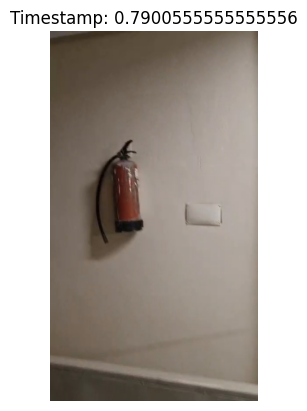

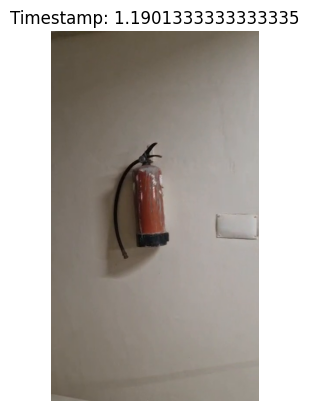

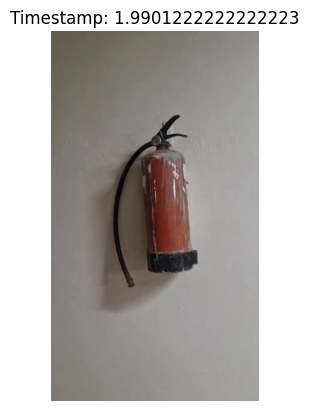

Item: 3
Status: YES
Confidence: 0.8
Comment: the fire extinguishers are kind of installed in an accessible and visible environment area



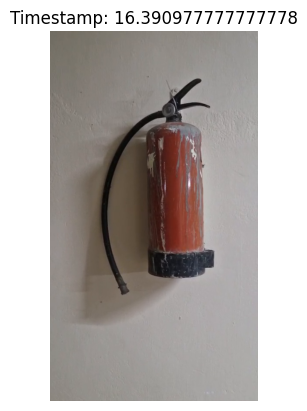

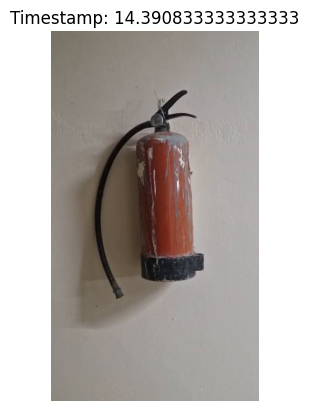

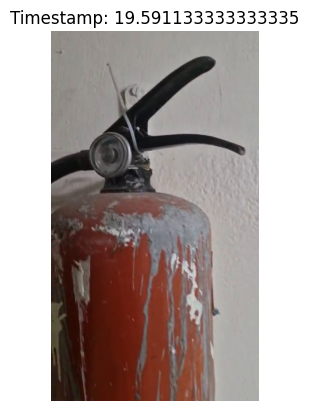

Item: 4
Status: YES
Confidence: 0.9
Comment: Locking fan and damper seal seems intact



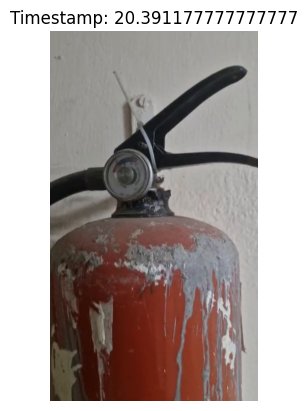

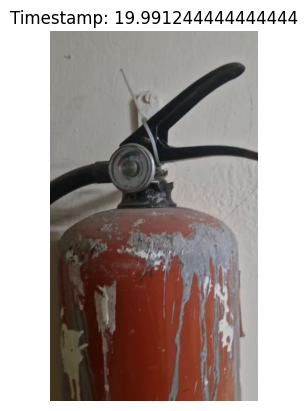

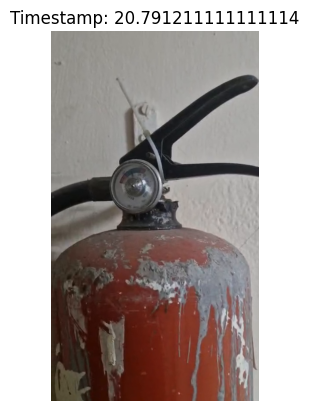

Item: 5
Status: YES
Confidence: 1.0
Comment: the pressure gauge is in green so it's in an operable range



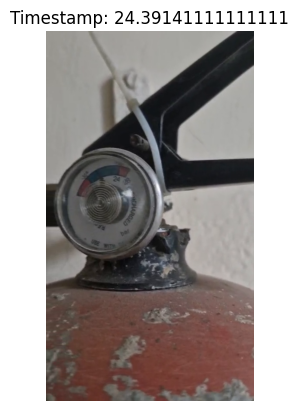

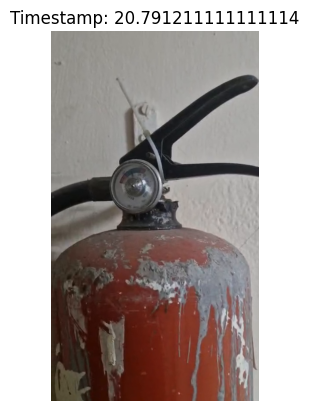

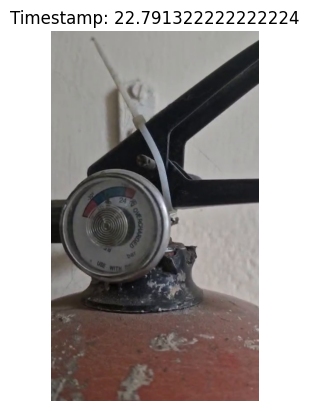

Item: 6
Status: NO
Confidence: 0.9
Comment: the operating instructions are not sticking outwards



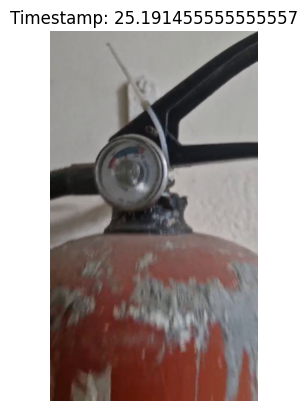

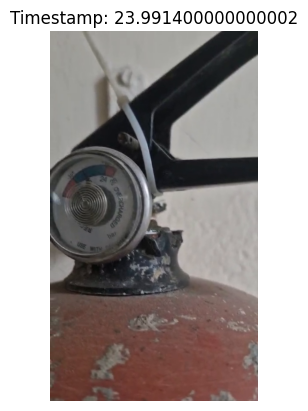

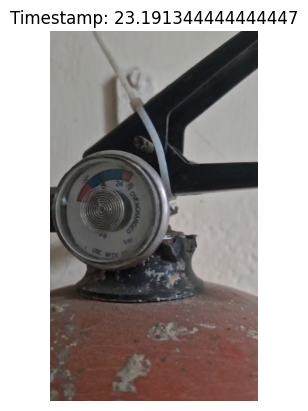

Item: 7
Status: NO
Confidence: 1.0
Comment: there are visible signs of corrosion, damage



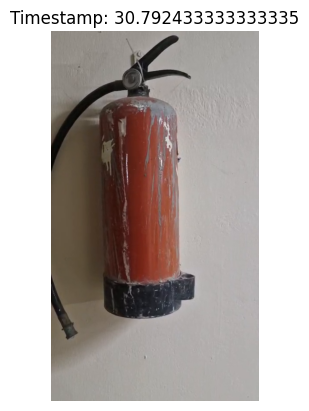

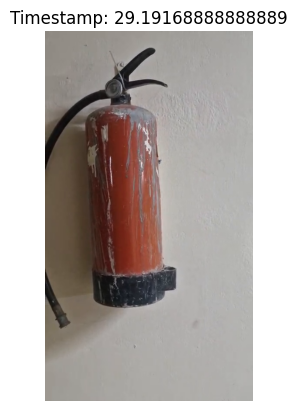

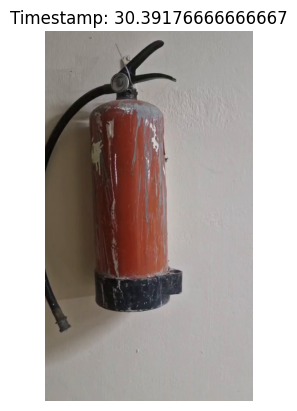

Item: 8
Status: NO
Confidence: 1.0
Comment: the professional service was not carried out within the 12 months



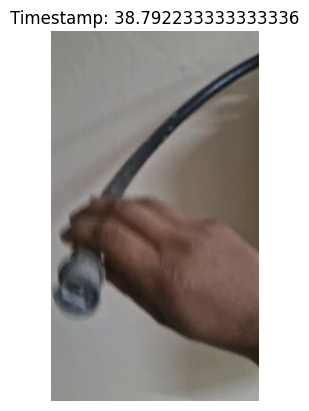

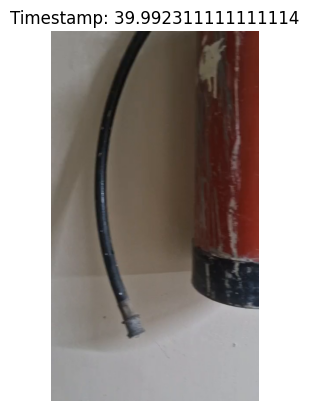

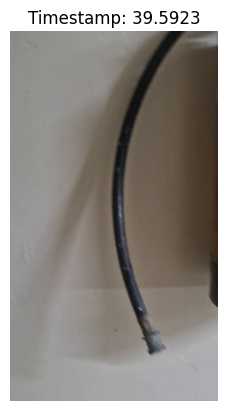

{'item_id': 1, 'status': 'YES', 'comment': 'the fire extinguishers are present between every 75 to 50 feet', 'date': None, 'evidence_frames': [{'timestamp': 0.7900555555555556}, {'timestamp': 1.1901333333333335}, {'timestamp': 1.9901222222222223}], 'confidence_score': 1.0}
{'item_id': 3, 'status': 'YES', 'comment': 'the fire extinguishers are kind of installed in an accessible and visible environment area', 'date': None, 'evidence_frames': [{'timestamp': 16.390977777777778}, {'timestamp': 14.390833333333333}, {'timestamp': 19.591133333333335}], 'confidence_score': 0.8}
{'item_id': 4, 'status': 'YES', 'comment': 'Locking fan and damper seal seems intact', 'date': None, 'evidence_frames': [{'timestamp': 20.391177777777777}, {'timestamp': 19.991244444444444}, {'timestamp': 20.791211111111114}], 'confidence_score': 0.9}
{'item_id': 5, 'status': 'YES', 'comment': "the pressure gauge is in green so it's in an operable range", 'date': None, 'evidence_frames': [{'timestamp': 24.39141111111111}

In [70]:
results = run_inspection_pipeline("/content/test2.mp4")
show_results_with_frames(results, "/content/test2.mp4")

for r in results:
    print(r)
